---
title: "PM Data"
execute:
  echo: false
  output: false
---

This notebook is a first pass on pulling and visualizing PM data stored on the [Open Storage Network](https://openstoragenetwork.readthedocs.io/en/latest/index.html)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import more_itertools as mit

sns.set()

In [2]:
pm_labels = {
    'pm0_1': 'PM$_{0.1}$',
    'pm0_3': 'PM$_{0.3}$',
    'pm0_5': 'PM$_{0.5}$',
    'pm1_0': 'PM$_{1}$',
    'pm2_5': 'PM$_{2.5}$',
    'pm5_0': 'PM$_5$',
    'pm10_0': 'PM$_{10}$'
}
pc_labels = {
    'pc0_1': 'PC$_{0.1}$',
    'pc0_3': 'PC$_{0.3}$',
    'pc0_5': 'PC$_{0.5}$',
    'pc1_0': 'PC$_{1}$',
    'pc2_5': 'PC$_{2.5}$',
    'pc5_0': 'PC$_5$',
    'pc10_0': 'PC$_{10}$'
}

nice_labels = {
    'dateTime': 'dateTime',
    'pm0_1': 'PM$_{0.1}$',
    'pm0_3': 'PM$_{0.3}$',
    'pm0_5': 'PM$_{0.5}$',
    'pm1_0': 'PM$_{1}$',
    'pm2_5': 'PM$_{2.5}$',
    'pm5_0': 'PM$_5$',
    'pm10_0': 'PM$_{10}$',
    'pc0_1': 'PC$_{0.1}$',
    'pc0_3': 'PC$_{0.3}$',
    'pc0_5': 'PC$_{0.5}$',
    'pc1_0': 'PC$_{1}$',
    'pc2_5': 'PC$_{2.5}$',
    'pc5_0': 'PC$_5$',
    'pc10_0': 'PC$_{10}$',
    'temperature': 'Temperature',
    'pressure': 'Pressure',
    'humidity': 'Humidity',
    'altitude': 'Altitude'
}


In [3]:
def loadData(url):
    """ 
    Load in data from a given url and parse the datatime column. If needed, convert timezones and set datetime as index. 

    Args:
        string containing the url.

    Returns:
        dataframe
    """
    # server_timezone = "UTC"
    # new_timezone = "US/Central"
    df = pd.read_csv(url)
    df['dateTime'] = pd.to_datetime(df['dateTime'])
    # df.columns = []
    # df['dateTime_HH'] = pd.to_datetime(df['dateTime'].dt.strftime('%H:%M'))
    # df = df.set_index('dateTime')
    # df.index = df.index.tz_localize(tz='UTC').tz_convert(tz='US/Central')

    return df

In [4]:
#| echo: true
#| output: true
# read bme data from url for may 2nd
bme_url = "https://ncsa.osn.xsede.org/ees230012-bucket01/AirQualityNetwork/data/central-node-8/2023/05/02/MINTS_001e06323a37_BME280_2023_05_02.csv"
bme_df = loadData(bme_url)
bme_df.head()

,dateTime,temperature,pressure,humidity,altitude
0,2023-05-02 00:00:01.768982,23.12,99579.0,31.0,146.37
1,2023-05-02 00:00:11.784763,23.14,99573.0,31.0,146.87
2,2023-05-02 00:00:21.815439,23.12,99577.0,31.0,146.54
3,2023-05-02 00:00:31.846306,23.12,99572.0,30.0,146.96
4,2023-05-02 00:00:41.861709,23.12,99570.0,30.0,147.13


In [5]:
#| echo: true
#| output: true
ips_url = "https://ncsa.osn.xsede.org/ees230012-bucket01/AirQualityNetwork/data/central-node-8/2023/05/02/MINTS_001e06323a37_IPS7100_2023_05_02.csv"
ips_df = loadData(ips_url)
ips_df.head()

,dateTime,pc0_1,pc0_3,pc0_5,pc1_0,pc2_5,pc5_0,pc10_0,pm0_1,pm0_3,pm0_5,pm1_0,pm2_5,pm5_0,pm10_0
0,2023-05-02 00:00:00.153699,11512,5101,1093,93,16,0,0,0.009619,0.124717,0.238913,0.316666,0.443954,0.443954,0.443954
1,2023-05-02 00:00:01.154625,11426,4975,1096,94,22,0,0,0.009547,0.121789,0.236346,0.315338,0.490778,0.490778,0.490778
2,2023-05-02 00:00:02.155689,11382,4851,1092,95,28,0,0,0.009511,0.118964,0.233116,0.312875,0.533701,0.533701,0.533701
3,2023-05-02 00:00:03.156913,11412,4737,1086,96,33,0,0,0.009536,0.116425,0.229902,0.310250,0.573414,0.573414,0.573414
4,2023-05-02 00:00:04.157472,11597,4747,1077,96,38,0,0,0.009691,0.116800,0.229366,0.310305,0.614702,0.614702,0.614702


In [6]:
import matplotlib.pylab as pylab

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

def plotPMwithAQS(df, pm_size):
    # The plotting function should also take in a time range, right?
    """ 
    Plot a relevant PM concentration with 24-hr AQ standards from WHO, EEA, EPA

    Args:
        pm dataframe, pm_size to plot (as a string, "pm2_5",  "pm10_0", etc.)

    Returns:
        Nothing. Plot created
    
    """

    fig, ax = plt.subplots(figsize=(12,8), tight_layout=True)
    ax.plot(df['dateTime'], df[pm_size], label=pm_labels[pm_size], color='orange')    
    # plt.plot(pm_df['dateTime'], pm_df['pm2_5'].rolling(3600).mean(), label='1H SMA')
    
    if pm_size == 'pm2_5':
        plt.axhline(y=25, ls='--', c='r', label='WHO & EEA')
        plt.axhline(y=35, ls='--', c='purple', label='EPA')
        ax.set_ylabel(f'{pm_labels[pm_size]} concentration ($\mu g/ m^3$)' )
        plt.title(f'Measured {pm_labels[pm_size]} Levels and \nRecommended 24HR Air Quality Standards')
    ## add pm_10 AQS as well, all else don't have AQS yet
    else:        
        ax.set_ylabel(f'{pm_labels[pm_size]} concentration ($\mu g/ m^3$)' )
        plt.title(f'Measured {pm_labels[pm_size]} Levels')

    
    plt.xticks(rotation=45)
    ## the x-label would change based on the timescale, need to account for that
    plt.xlabel('Time in UTC (MM:DD HH)')

    ax.margins(x=0)
    plt.ylim(0,)
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend()

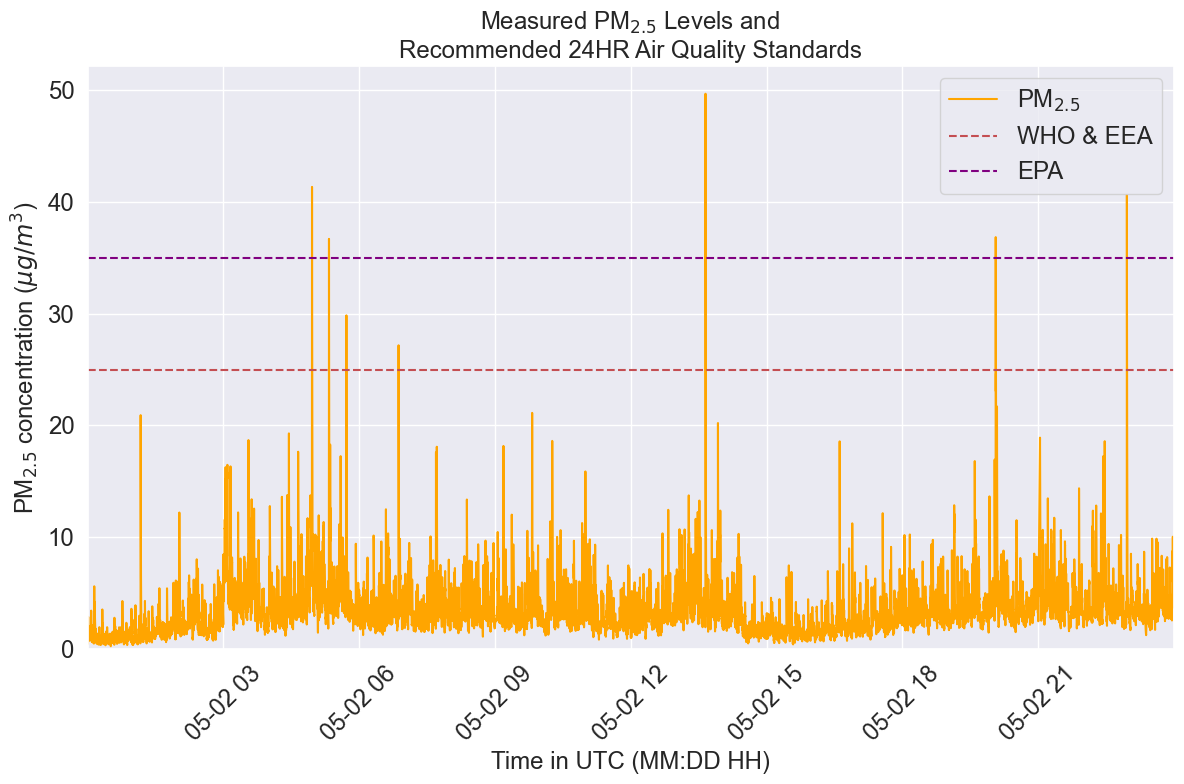

In [7]:
# | echo: false
#| output: true
plotPMwithAQS(ips_df, 'pm2_5')

In [8]:
def pmStats(df, pm_kind=None, time_range=None):
    ''' 
    Provide statistics about a desired PM concentration

    Args:
        pm dataframe, pm bin and time range to give stats over need to be added
    
    Returns:
        Nothing for now, prints a bunch of statements
    '''
    who_threshold = df[df['pm2_5'] > 25]
    above_threshold = [list(group) for group in mit.consecutive_groups(who_threshold.index)]
    print(f"Number of PM2.5 datapoints above the WHO recommended threshold: {len(who_threshold)}")
    print(f"Number of separate instances the threshold was crossed: {len(above_threshold)}")

    return len(who_threshold), len(above_threshold)

In [9]:
# num_points, num_crossed = pmStats(ips_df)

In [10]:
# from IPython.display import Markdown as md

# fr=2 #GHz

# md("$f_r = %i$ GHz"%(fr))

In [11]:
# md('Number of PM$_{2.5}$ datapoints above the WHO recommended threshold: %i'%(num_points))

In [12]:
#| echo: false
#| output: true
pmStats(ips_df)

Number of PM2.5 datapoints above the WHO recommended threshold: 88
Number of separate instances the threshold was crossed: 7


(88, 7)

# Demo: Showing distribution of PM

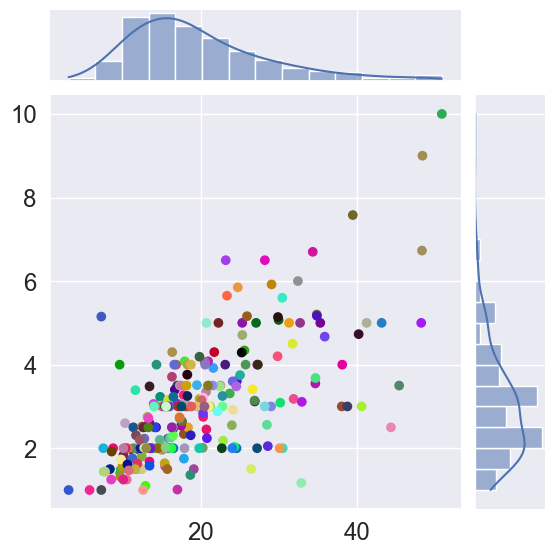

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

tips = sns.load_dataset("tips")
g = sns.jointplot(data=tips, x="total_bill", y="tip", kind="reg", 
                  xlim=(0, 60), ylim=(0, 12))


g.ax_joint.cla() # or g.ax_joint.collections[0].set_visible(False), as per mwaskom's comment

# set the current axis to be the joint plot's axis
plt.sca(g.ax_joint)

# plt.scatter takes a 'c' keyword for color
# you can also pass an array of floats and use the 'cmap' keyword to
# convert them into a colormap
plt.scatter(tips.total_bill, tips.tip, c=np.random.random((len(tips), 3)))

In [14]:
ips_df['dateTime'][0].to_pydatetime().strftime('%Y/%m/%d')

'2023/05/02'

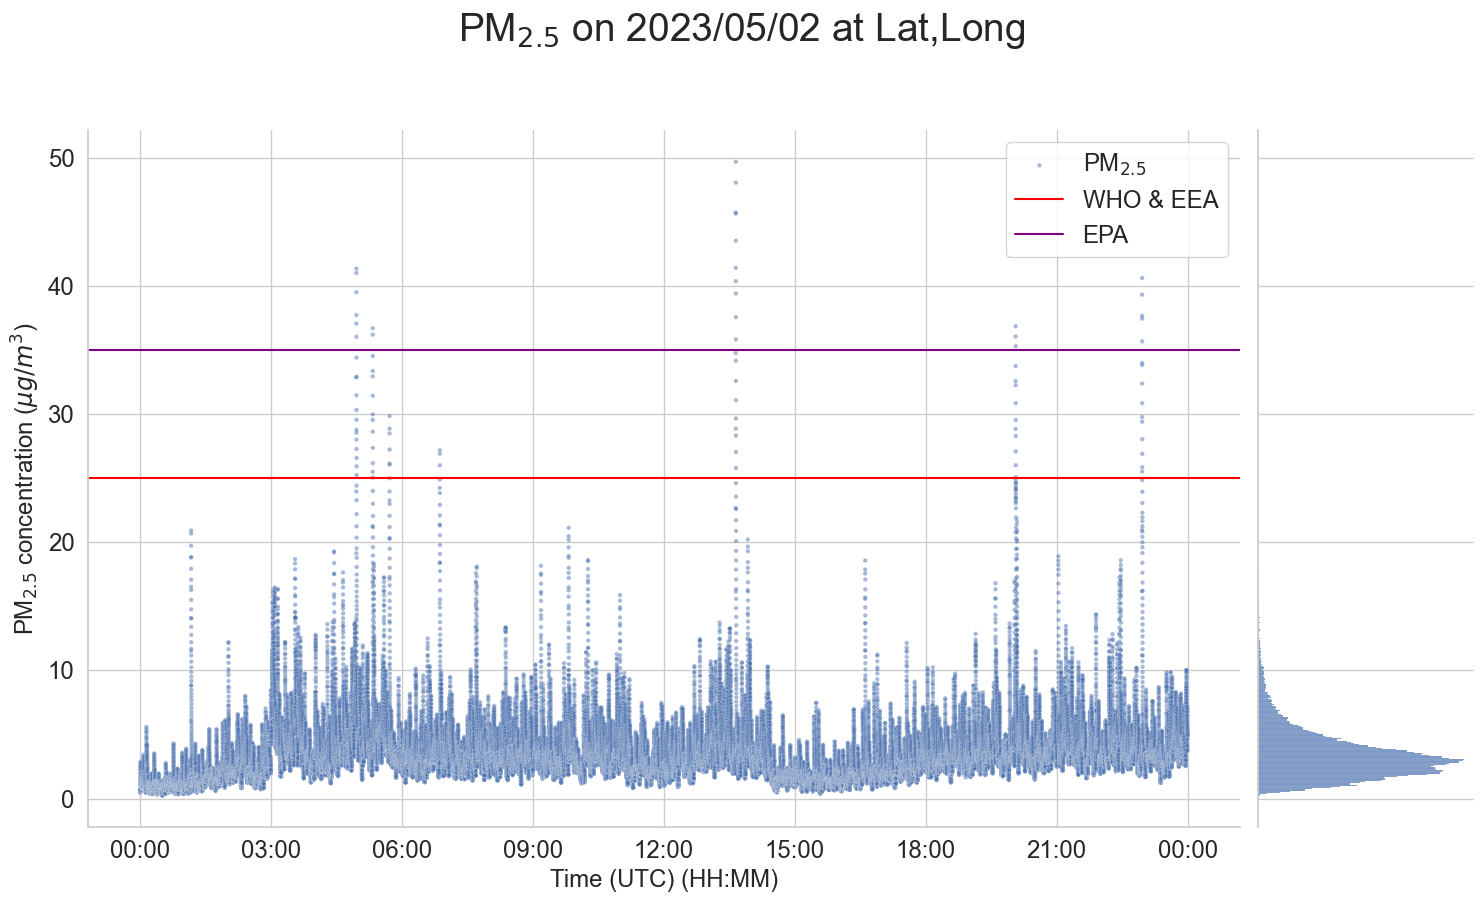

In [15]:
#| echo: false
#| output: true
import matplotlib.dates as mdates
# import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
# sns.set_style('ticks')
sns.set_style('whitegrid')

def plotPMdistribution(df, pm_size=None):
    ''' 
    plot the distribution of PM concentration for a given timerange
    
    Args:
    dataframe containing pm data, size of the pm to be plotted (do we want multiple pm on one graph?)

    Returns:
    Nothing. Produces one plot
    '''
    # list_of_pm = list(df.filter(like='pm',axis=1).columns)
    # # creating the plot
    # for pm_size in list_of_pm:
    g = sns.jointplot(x=df['dateTime'], y=df[pm_size], s=10, alpha=0.5, ls='-.', label=f'{pm_labels[pm_size]}')
    g.ax_marg_x.remove() # removing the x-axis distribution, any other way?
    g.fig.set_size_inches((15, 10))

    # drawing two horizontal lines 
    if pm_size == 'pm2_5':
        g.ax_joint.axhline(y=25, color='red', label='WHO & EEA')
        g.ax_joint.axhline(y=35, color='purple', label='EPA')
        g.ax_joint.legend(labels=['WHO & EEA','EPA'])
        # creating legend items, do we need the next line
    handles, labels = g.ax_joint.get_legend_handles_labels()
    g.ax_joint.legend(handles=handles, labels=[f'{pm_labels[pm_size]}'].append(labels))

    # plot title and axis labels
    # including the date on dateTime column on the first row in the dataframe. potential issues could occur with regards to UTC timezone maybe?
    title_date = df['dateTime'][0].to_pydatetime().strftime('%Y/%m/%d')
    g.fig.suptitle(f'{pm_labels[pm_size]} on {title_date} at Lat,Long', size=28, y=0.9)
    g.set_axis_labels('Time (UTC) (HH:MM)', f'{pm_labels[pm_size]} concentration ($\mu g/ m^3$)')
    # g.fig.suptitle(f'PM levels on {ips_df["dateTime"].dt.date[0]} at Lat,Long', size=20, y=0.9)
    # g.set_axis_labels('Time (UTC) (HH:MM)', f'PM concentration ($\mu g/ m^3$)')

    # mdates does a good job of getting exact datetime labels on the ticks
    g.ax_joint.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,24,3)))
    g.ax_joint.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))



    plt.tight_layout()
    # plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()

plotPMdistribution(ips_df, 'pm2_5')

# Calculate Mutual Information between PM measurements and environmental data

In [16]:
ips_df

,dateTime,pc0_1,pc0_3,pc0_5,pc1_0,pc2_5,pc5_0,pc10_0,pm0_1,pm0_3,pm0_5,pm1_0,pm2_5,pm5_0,pm10_0
0,2023-05-02 00:00:00.153699,11512,5101,1093,93,16,0,0,0.009619,0.124717,0.238913,0.316666,0.443954,0.443954,0.443954
1,2023-05-02 00:00:01.154625,11426,4975,1096,94,22,0,0,0.009547,0.121789,0.236346,0.315338,0.490778,0.490778,0.490778
2,2023-05-02 00:00:02.155689,11382,4851,1092,95,28,0,0,0.009511,0.118964,0.233116,0.312875,0.533701,0.533701,0.533701
3,2023-05-02 00:00:03.156913,11412,4737,1086,96,33,0,0,0.009536,0.116425,0.229902,0.310250,0.573414,0.573414,0.573414
4,2023-05-02 00:00:04.157472,11597,4747,1077,96,38,0,0,0.009691,0.116800,0.229366,0.310305,0.614702,0.614702,0.614702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85890,2023-05-02 23:59:55.336549,67558,22747,8693,337,407,0,0,0.056449,0.569636,1.477632,1.759369,4.952508,4.952508,4.952508
85891,2023-05-02 23:59:56.337526,67468,22820,8626,339,404,0,0,0.056374,0.571215,1.472137,1.755763,4.924822,4.924822,4.924822
85892,2023-05-02 23:59:57.338967,67426,22918,8552,340,403,0,0,0.056339,0.573373,1.466587,1.751157,4.912748,4.954716,4.954716
85893,2023-05-02 23:59:58.341340,67376,23193,8475,340,414,7,0,0.056297,0.579546,1.464775,1.749404,5.000098,5.495581,5.495581


In [17]:
bme_df

,dateTime,temperature,pressure,humidity,altitude
0,2023-05-02 00:00:01.768982,23.12,99579.0,31.0,146.37
1,2023-05-02 00:00:11.784763,23.14,99573.0,31.0,146.87
2,2023-05-02 00:00:21.815439,23.12,99577.0,31.0,146.54
3,2023-05-02 00:00:31.846306,23.12,99572.0,30.0,146.96
4,2023-05-02 00:00:41.861709,23.12,99570.0,30.0,147.13
...,...,...,...,...,...
8536,2023-05-02 23:59:12.361301,26.36,99668.0,50.0,138.86
8537,2023-05-02 23:59:22.377294,26.37,99673.0,50.0,138.43
8538,2023-05-02 23:59:32.407801,26.33,99668.0,50.0,138.86
8539,2023-05-02 23:59:42.438916,26.31,99666.0,50.0,139.03


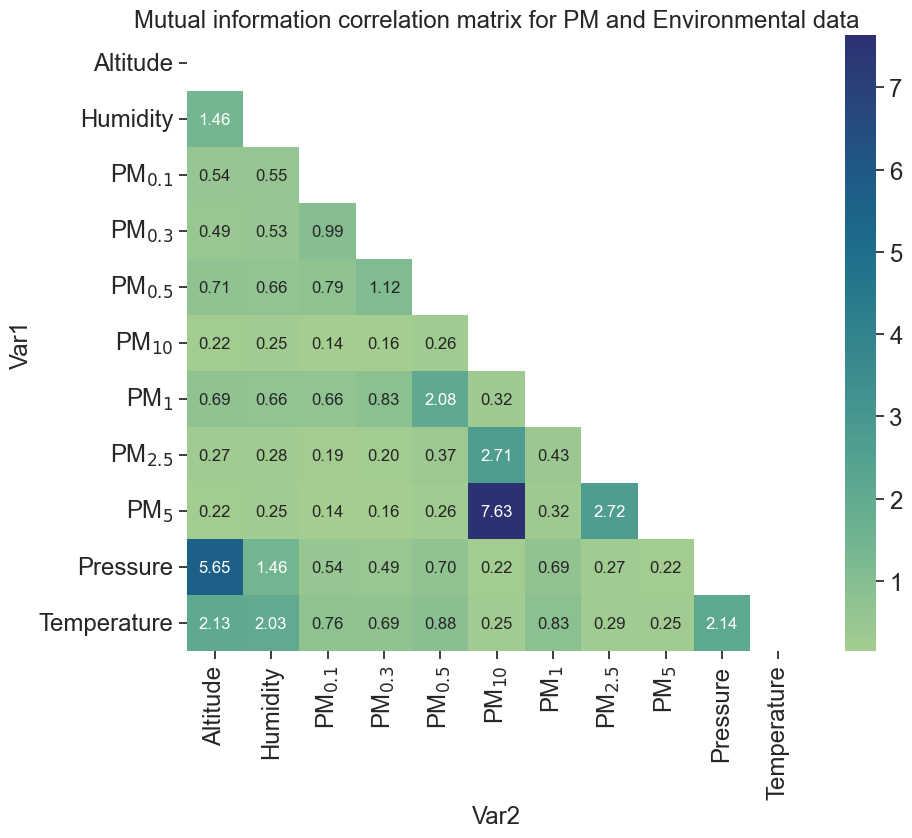

In [18]:
#| echo: false
#| output: true

from itertools import combinations
from sklearn.feature_selection import mutual_info_regression
from itertools import permutations

merged_df = pd.merge_asof(bme_df, ips_df, on='dateTime', direction='nearest')
merged_df = merged_df.loc[:,~merged_df.columns.str.contains('pc')].drop('dateTime', axis=1)

sns.set_style('ticks')

def plotMutualInformation(df):
    #ECG, Resp, PPG, SpO2, HR, Temp, PM10, PM4, PM25, PM1, dCn
    # non_eeg = ['ECG.', 
    premutual_df = df.copy()
    # combines = list(combinations(premutual_df.columns, 2))
    combines = list(permutations(premutual_df.columns,2))
    
    mi_list = []
    for i in combines:
        # print(i)

        mi = mutual_info_regression(df.loc[:,i[0]].to_numpy().reshape(-1,1), df.loc[:,i[1]].to_numpy())
        mi_list.append(mi)
        # print(f"Mutual information between {i[0]} and {i[1]} is: {mi}")
    
    mi_df = pd.DataFrame({'Var1': [i[0] for i in combines], 'Var2': [i[1] for i in combines], 'Mutual Information': [i[0] for i in mi_list]})
    mi_df = mi_df.pivot(index='Var1', columns='Var2', values='Mutual Information')

    mask = np.zeros_like(mi_df, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    # mi_df = mi_df.sort_values(by=['Mutual Information'])
#     sorted_cols = mi_df.isna().sum().sort_values(ascending=False).index
#     mi_df = mi_df.reindex(columns=sorted_cols)
#     mi_df = mi_df.reindex(['ECG.','Resp.','PPG','SpO2','HR','Temp.','pm10_palas','pm4_palas','pm2_5_palas','pm1_palas','pmTotal_palas'])
    
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.heatmap(mi_df, mask=mask, cmap='crest', annot=True, fmt=".2f")


    
    ax.set_yticklabels([nice_labels[i] for i in mi_df.index])
    ax.set_xticklabels([nice_labels[i] for i in mi_df.index])

    plt.title(f'Mutual information correlation matrix for PM and Environmental data')
    plt.show()
    # return mi_df
    
    # return fig 

plotMutualInformation(merged_df)